In [1]:
import numpy as np
import copy
from sklearn.neural_network import MLPRegressor
from numpy.random import *
from operator import itemgetter

# 1.InputFieldData

In [2]:
def sortPosInfo(pos_list_with_num,info_name):
    np_pos_list_with_num = np.asarray(pos_list_with_num)
    sorted_np_pos_list_with_num = np.array(sorted(np_pos_list_with_num,key=itemgetter(1)))
    pos_list = []
    for pos_info in sorted_np_pos_list_with_num:
        pos_list.append(pos_info[0])
    print("{0} = {1}".format(info_name,pos_list))
    return pos_list

In [3]:
def inputFieldData(text_path):
    f = open(text_path)
    line = f.readline()
    line_count = 1
    field_size = int(len(line) / 2)
    field = np.empty((0,field_size),int)
    agents_pos_list = []
    goal_pos_list = []
    while line:
        last_idx = line.find("\n")
        field_row = np.array([])
        for i in range(0,last_idx,2):
            field_row = np.append(field_row,int(line[i]))
            if int(line[i]) % 2 == 0 and int(line[i]) != 0:
                agent_data = np.array([np.array([line_count-1,int(i/2)]),int(line[i])])
                agents_pos_list.append(agent_data)
            if int(line[i]) % 2 == 1 and int(line[i]) != 1:
                goal_data = np.array([np.array([line_count-1,int(i/2)]),int(line[i])])
                goal_pos_list.append(goal_data)
        field = np.append(field,np.array([field_row]),axis=0)
        line = f.readline()
        line_count += 1
    f.close()
    print("init field = \n {0}".format(field))
    agents_pos_list = sortPosInfo(agents_pos_list,"agents_pos_list")
    goal_pos_list = sortPosInfo(goal_pos_list,"goal_pos_list")
    return field,agents_pos_list,goal_pos_list

In [4]:
init_field,agents_pos_list,goal_pos_list = inputFieldData("test.txt")
field_row = len(init_field[0])
field_col = len(init_field)

init field = 
 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  2.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  6.  1.  0.  1.  0.  1.]
 [ 1.  7.  1.  0.  0.  5.  1.  0.  1.]
 [ 1.  0.  3.  0.  4.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
agents_pos_list = [array([1, 1]), array([5, 4]), array([3, 3])]
goal_pos_list = [array([5, 2]), array([4, 5]), array([4, 1])]


# 2.DecideActions

In [5]:
def moveToNextPos(pos,action):
    if action == 0:
        next_pos = [pos[0]-1,pos[1]]
    elif action == 1:
        next_pos = [pos[0],pos[1]+1]
    elif action == 2:
        next_pos = [pos[0]+1,pos[1]]
    elif action== 3:
        next_pos = [pos[0],pos[1]-1]
    else:
        next_pos = [pos[0],pos[1]]
    return next_pos

In [6]:
def buildNetwork(X_train,y_train):
    clf = MLPRegressor(solver="adam",random_state=1,max_iter=1000,hidden_layer_sizes=(20,50,10))
    print("X_train.shape = {0} , y_train.shape = {1}".format(X_train.shape,y_train.shape))
    clf.fit(X_train,y_train)
    return clf

In [7]:
def checkNextField(action_data,poses,pred_actions,field,agent_num):
    next_poses = [moveToNextPos(poses[i],pred_actions[i]) for i in range(len(poses))]
    next_pos = next_poses[agent_num]
    action_flag = True
    #行動先が行動可能かどうか判定
    if field[next_pos[0],next_pos[1]] != 1: #行動先が壁でないとき
        for j in range(len(next_poses)):
            #エージェントの向きと真逆の方向へは移動できない
            if action_data:
                prev_action = action_data[-1][j]
                pred_action = pred_actions[j]
                if (prev_action == 0 and pred_action == 2) or (prev_action == 1 and pred_action == 3) or (prev_action == 2 and pred_action == 0) or (prev_action == 3 and pred_action == 1):
                    action_flag = False
            #行動先に先約があるとき
            if agent_num == j: continue
            if next_poses[agent_num] == next_poses[j]:
                action_flag = False
            #他エージェントと交差するとき
            if next_poses[agent_num] == poses[j] and next_poses[j] == poses[agent_num]:
                action_flag = False
    else:
        action_flag = False
    return action_flag

In [8]:
def checkAchievingGoal(poses,goal_flags):
    for i in range(len(poses)):
        if poses[i] == goal_pos_list[i].tolist():
            goal_flags[i] = True
    return goal_flags

In [9]:
def checkActions(action_data,pred_actions,field,poses,goal_flags):
    next_poses = []
    exit_flag = False
    for i in range(len(pred_actions)):
        next_poses.append(moveToNextPos(poses[i],pred_actions[i]))
        goal_flags = checkAchievingGoal(poses,goal_flags)
        if goal_flags[i]:
            pred_actions[i] = 4
    for i in range(len(next_poses)):
        if goal_flags[i]:
            continue
        #行動先が行動可能かどうか判定
        action_flag = checkNextField(action_data,poses,pred_actions,field,i)
        #行動不可能なとき，注目するエージェントの行動先を変更
        cnt = 0
        while action_flag == False:
            pred_actions[i] = int(pred_actions[i] + rand() * 3 + 1) % 4
            action_flag = checkNextField(action_data,poses,pred_actions,field,i)
            cnt += 1
            if cnt > 100:
                exit_flag = True
                break
    goal_flags = checkAchievingGoal(poses,goal_flags)
    for i in range(len(goal_flags)):
        if goal_flags[i]:
            pred_actions[i] = 4 #停止
    return pred_actions,exit_flag

In [10]:
def predictActions(clf,field):
    X_test = np.asarray(field).reshape(1,field_row*field_col)
    actions = clf.predict(X_test)[0]
    for i in range(len(actions)):
        actions[i] = int(actions[i])
        
    if rand() < 0.3:
        for i in range(len(actions)):
            actions[i] = int(actions[i] + rand() * 3 + 1) % 4
    return actions

In [11]:
#特殊地点：エージェントのゴール地点
def updateField(poses,next_poses,field):
    for i in range(len(agents_pos_list)):
        pos = poses[i]
        next_pos = next_poses[i]
        #エージェントがいずれかの方向に進行する場合
        if pos != next_pos:
            #現在いる地点が特殊地点でないとき
            if field[pos[0],pos[1]] % 2 == 0:
                field[pos[0],pos[1]] = 0
            #現在いる地点が特殊地点のときは現在地の値は変更しない
            
            #遷移先が特殊地点でないとき
            if field[next_pos[0],next_pos[1]] % 2 == 0:
                field[next_pos[0],next_pos[1]] = i*2 + 2
            #遷移先が特殊地点のときは遷移先の値は変更しない

In [12]:
def printFieldData(field_data,action_data):
    for i in range(len(field_data)):
        print(field_data[i])
        print(action_data[i])
    print("--------------------------------------------------")

In [95]:
FIND_ROOT_MAX_LOOP = 50
def createTrainData(init_field,init_poses,clf,path_count,best_field_data,best_action_data,last_poses):
    field_data = [copy.deepcopy(init_field)]
    field = copy.deepcopy(init_field)
    poses = init_poses
    action_data = []
    goal_flags = [False for i in range(len(poses))]
    create_flag = False
    exit_flag = False
    first_goal_flag = False
    dummy_first_goal_idx = -1
    dummy_first_goal_poses = []
    for i in range(FIND_ROOT_MAX_LOOP):
        if clf != None:
            pred_actions = predictActions(clf,field)
        else:
            pred_actions = [int(rand()*4) for i in range(len(agents_pos_list))]
        #予測したアクションに対してチェックを行い，壁や他エージェントにぶつかる挙動を変更する
        actions,exit_flag = checkActions(action_data,pred_actions,field,poses,goal_flags)
        if (goal_flags[0] or goal_flags[1] or goal_flags[2]) and first_goal_flag == False:
            first_goal_flag = True
            dummy_first_goal_idx = len(action_data)
            dummy_first_goal_poses = copy.deepcopy(poses)
        if exit_flag:
            break
        #タイムステップ毎のアクションを保持するaction_dataの末尾に次の行動を追加
        action_data.append(actions)
        #actionsを元に次のfieldへと遷移させる
        next_poses = []
        for j in range(len(agents_pos_list)):
            next_poses.append(moveToNextPos(poses[j],actions[j]))
        updateField(poses,next_poses,field)
        field_data.append(copy.deepcopy(field))
        poses = next_poses
        if goal_flags[0] and goal_flags[1] and goal_flags[2]:
            action_data.append([4,4,4])
            np_field_data = np.asarray(field_data)
            np_action_data = np.asarray(action_data)
            if path_count > np_field_data.shape[0]:
                path_count = np_field_data.shape[0]
                clf = buildNetwork(np_field_data.reshape(np_field_data.shape[0],np_field_data.shape[1]*np_field_data.shape[2]),np_action_data)
#                 printFieldData(field_data,action_data)
                best_field_data = copy.deepcopy(field_data)
                print("dummy:{0}".format(dummy_first_goal_idx))
                global first_goal_field_idx
                global first_goal_field_poses
                first_goal_field_idx = dummy_first_goal_idx
                first_goal_field_poses = copy.deepcopy(dummy_first_goal_poses)
                best_action_data = copy.deepcopy(action_data)
                last_poses = copy.deepcopy(poses)
                create_flag = True
            break
#     for i in range(30):
#         print(field_data[i])
#         print("action = {0} \n".format(action_data[i]))
#     print("--------------------------------------------------")
    return  last_poses,clf,path_count,best_field_data,best_action_data,create_flag

In [185]:
def runCreatingPath(agents_pos_list,init_field):
    clf = None
    path_count = 1e+7
    agents_poses = []
    best_field_data = []
    best_action_data = []
    last_poses = []
    for agents_pos in agents_pos_list:
        agents_poses.append(agents_pos.tolist())
    create_flag = False
    cnt = 0
    for i in range(4000):
        if create_flag == False:
            cnt += 1
        else:
            cnt = 0
        if cnt > 1000:
            break
        init_poses = agents_poses
        if (i+1)  % 100 == 0:
            print("epoch = {0}".format(i+1))
        last_poses,clf,path_count,best_field_data,best_action_data,create_flag = createTrainData(init_field,init_poses,clf,path_count,best_field_data,best_action_data,last_poses)
    return best_field_data,best_action_data,last_poses

In [186]:
def createNewField(last_field,last_poses):
#     for i in range(len(last_poses)):
#         pos = last_poses[i]
#         last_field[pos[0],pos[1]] = i*2 + 2
#     for i in range(len(last_poses)):
#         goal_pos = [int(rand()*7),int(rand()*7)]
#         while last_field[goal_pos[0],goal_pos[1]] != 0:
#             goal_pos = [int(rand()*7),int(rand()*7)]
#         last_field[goal_pos[0],goal_pos[1]] = i*2 + 3
    
    f = open("test.txt","w")
    for i in range(len(last_field)):
        for j in range(len(last_field[0])):
            letter = str(int(last_field[i][j]))
            if j != len(last_field[0]) - 1:
                letter += ","
            else:
                letter += "\n"
            f.write(letter)
    f.close()

In [187]:
def updateToNewField(last_field,last_poses):
    copy_last_field = copy.deepcopy(last_field)
    for (i,pos) in enumerate(last_poses):
        if copy_last_field[pos[0],pos[1]] % 2 != 0: #agentがゴール地点にいる場合
            copy_last_field[[pos[0]],pos[1]] = i*2 + 2
            new_goal_pos = [int(rand()*7),int(rand()*7)]
            while last_field[new_goal_pos[0],new_goal_pos[1]] != 0:
                new_goal_pos = [int(rand()*7),int(rand()*7)]
            copy_last_field[new_goal_pos[0],new_goal_pos[1]] = i*2 + 3
#     copy_last_field = copy.deepcopy(last_field)
#     goal_indices = np.where((last_field % 2 != 0) & (last_field != 1))
#     y_indices = goal_indices[0]
#     x_indices = goal_indices[1]
#     for x_idx,y_idx in zip(x_indices,y_indices):
#         copy_last_field[y_idx,x_idx] = 0
#     for (i,pos) in enumerate(last_poses):
#         copy_last_field[pos[0],pos[1]] = i*2 + 3
    return copy_last_field,last_poses

In [192]:
first_goal_field_idx = -1
first_goal_field_poses = []
all_field_data = []
for i in range(6):
    init_field,agents_pos_list,goal_pos_list = inputFieldData("test.txt")
    best_field_data, best_action_data, last_poses = runCreatingPath(agents_pos_list,init_field)
    if best_field_data:
#         last_field = copy.deepcopy(best_field_data[-1])
        last_field = copy.deepcopy(best_field_data[first_goal_field_idx])
        best_field_data = best_field_data[:first_goal_field_idx + 1]
        best_action_data = best_action_data[:first_goal_field_idx + 1]
        all_field_data.append(copy.deepcopy(best_field_data))
        last_field,last_poses = updateToNewField(last_field,first_goal_field_poses)
        printFieldData(best_field_data,best_action_data)
        createNewField(last_field,last_poses)

init field = 
 [[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  6.  0.  0.  7.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  5.  1.  0.  1.  2.  1.  0.  1.]
 [ 1.  0.  1.  3.  0.  0.  1.  0.  1.]
 [ 1.  0.  0.  4.  0.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
agents_pos_list = [array([3, 5]), array([5, 3]), array([1, 2])]
goal_pos_list = [array([4, 3]), array([3, 1]), array([1, 5])]
X_train.shape = (43, 63) , y_train.shape = (43, 3)
dummy:3
epoch = 100
epoch = 200
epoch = 300
X_train.shape = (23, 63) , y_train.shape = (23, 3)
dummy:12
epoch = 400
epoch = 500
X_train.shape = (10, 63) , y_train.shape = (10, 3)


/usr/local/lib/python3.4/dist-packages/sklearn/neural_network/multilayer_perceptron.py:563: ConvergenceWarning: Stochastic Optimizer: Maximum iterations reached and the optimization hasn't converged yet.
  % (), ConvergenceWarning)


dummy:3
epoch = 600
X_train.shape = (6, 63) , y_train.shape = (6, 3)
dummy:3
epoch = 700
epoch = 800
epoch = 900
epoch = 1000
epoch = 1100
epoch = 1200
epoch = 1300
epoch = 1400
epoch = 1500
epoch = 1600
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  6.  0.  0.  7.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  5.  1.  0.  1.  2.  1.  0.  1.]
 [ 1.  0.  1.  3.  0.  0.  1.  0.  1.]
 [ 1.  0.  0.  4.  0.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
[ 2.  3.  1.]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  6.  0.  7.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  5.  1.  0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  3.  0.  2.  1.  0.  1.]
 [ 1.  0.  4.  0.  0.  0.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
[ 3.  3.  1.]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  0.  0.  0.  6.  7.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  5.  1.  0.  1.  0.  1.  0.  1.]
 [ 1.  0.  1.  3.  2.  0.  1.  0.  1.]
 [ 1.  4.  0.  0.  0.  0.

epoch = 200
epoch = 300
X_train.shape = (21, 63) , y_train.shape = (21, 3)
dummy:3
epoch = 400
epoch = 500
epoch = 600
epoch = 700
epoch = 800
X_train.shape = (19, 63) , y_train.shape = (19, 3)
dummy:4
X_train.shape = (11, 63) , y_train.shape = (11, 3)
dummy:8
epoch = 900
epoch = 1000
epoch = 1100
epoch = 1200
epoch = 1300
epoch = 1400
epoch = 1500
epoch = 1600
epoch = 1700
epoch = 1800
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  4.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  3.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.  0.  1.]
 [ 1.  5.  1.  0.  2.  0.  1.  0.  1.]
 [ 1.  0.  7.  0.  0.  0.  6.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
[ 2.  5.  3.]
[[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  4.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  3.  1.  0.  1.  0.  0.  0.  1.]
 [ 1.  0.  1.  0.  1.  0.  1.  0.  1.]
 [ 1.  5.  1.  0.  0.  0.  1.  0.  1.]
 [ 1.  0.  7.  0.  2.  6.  0.  0.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.]]
[ 3.  1.  3.]
[[ 1.  1.  1.  1.  1.  1.  1.  1. 

In [193]:
import cv2
import os
import shutil
def arrayToImage(all_field_data):
    path = "FieldData"
    if os.path.isdir(path):
        shutil.rmtree(path)
    os.mkdir(path)
    copy_best_field_data = copy.deepcopy(all_field_data)
    scale = 100
    for (num,field) in enumerate(copy_best_field_data):
        color_field = []
        scaled_field = []
        for i in range(len(field)):
            color_field_row = []
            for j in range(len(field[i])):
                rgb = []
                if field[i][j] == 0:
                    rgb = [255,255,255]
                elif field[i][j] == 1:
                    rgb = [0,0,0]
                elif field[i][j] == 2:
                    rgb = [255,0,0]
                elif field[i][j] == 3:
                    rgb = [200,0,0]
                elif field[i][j] == 4:
                    rgb = [0,255,0]
                elif field[i][j] == 5:
                    rgb = [0,200,0]
                elif field[i][j] == 6:
                    rgb = [0,0,255]
                elif field[i][j] == 7:
                    rgb = [0,0,200]
                color_field_row.append(rgb)
            color_field.append(color_field_row)
                
        
        for i in range(len(color_field)):
            field_row = []
            for j in range(len(color_field[i])):
                for k in range(scale):
                    field_row.append(color_field[i][j])
            for j in range(scale):
                scaled_field.append(field_row)
        np_scaled_field = np.asarray(scaled_field)
        path = "FieldData/field_{0}.png".format(num)
        cv2.imwrite(path,np_scaled_field)

In [194]:
reshaped_all_field_data = []
for field_data in all_field_data:
    for field in field_data:
        reshaped_all_field_data.append(field)
arrayToImage(reshaped_all_field_data)

<IPython.core.display.Javascript object>


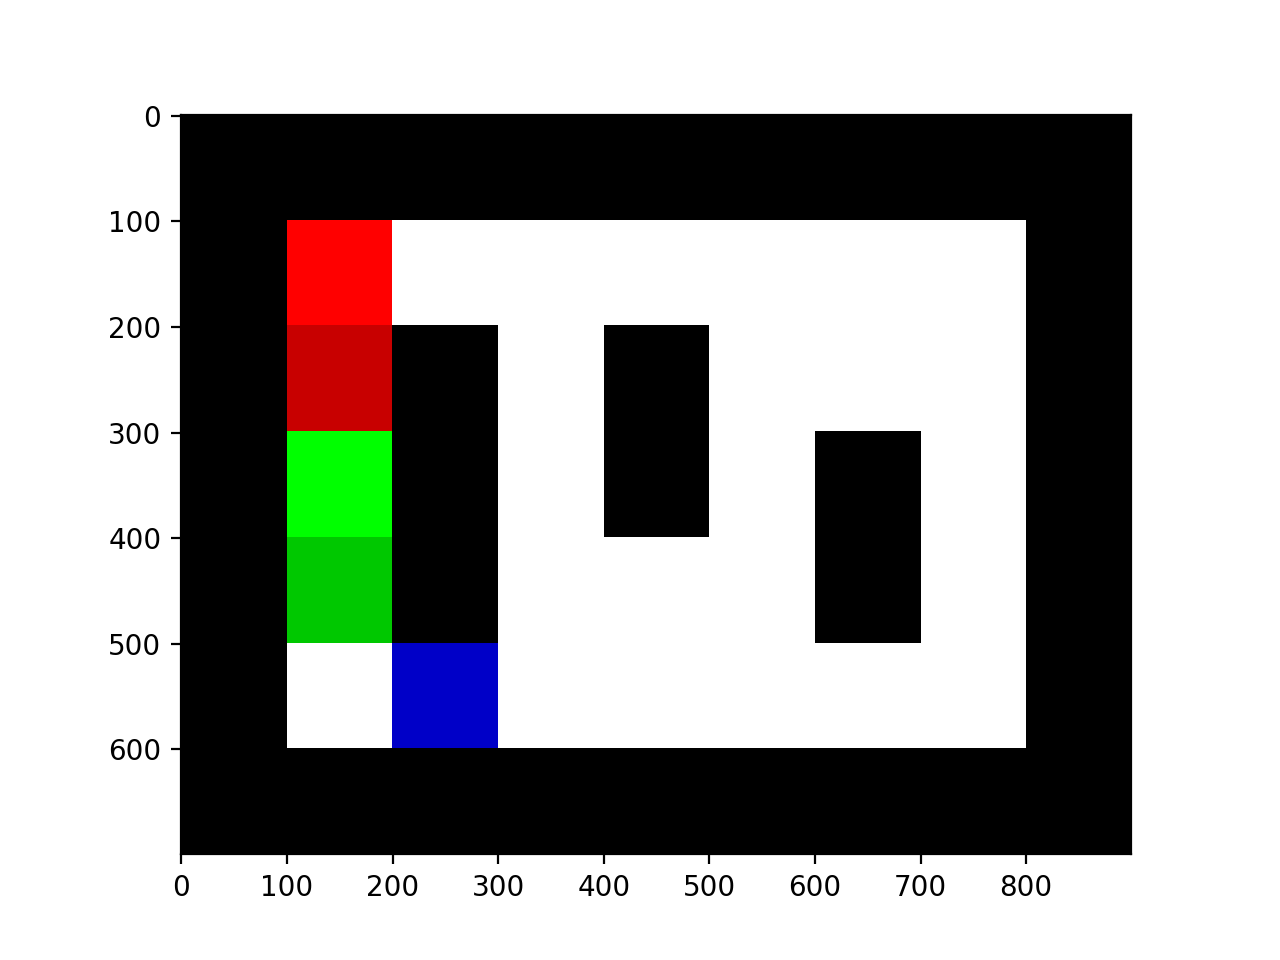

In [195]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import glob
%matplotlib nbagg

fig = plt.figure()

field_pathes = glob.glob("FieldData/*.png")
imgs = []
for i in range(len(field_pathes)):
    path = "FieldData/field_{0}.png".format(i)
    img = cv2.imread(path)
    imgs.append([plt.imshow(img)])
ani = animation.ArtistAnimation(fig, imgs, interval=1000, repeat_delay=1000)